In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gpytorch
import torch

# Generate dataset

In [52]:
# True function
def f(x):
    return 1+ np.sin(2 * np.pi * x)
# Heteroscedastic noise
def noise_std(x):
    return 0.1 + 0.4 * np.cos(3 * np.pi * x)**2

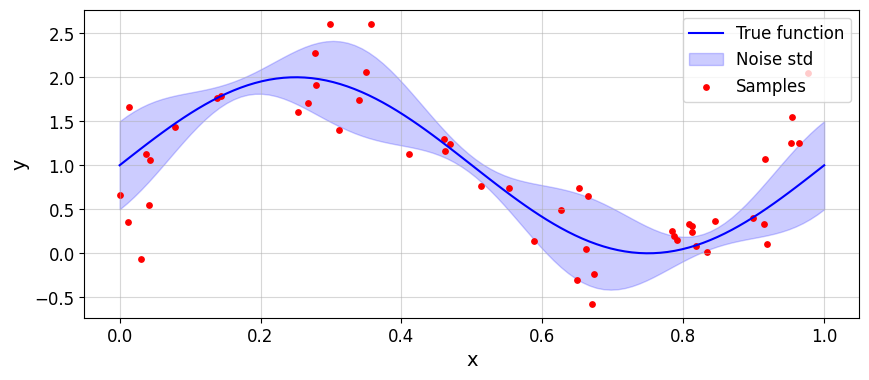

In [53]:
n = 50

# initialise graph
plt.figure(figsize=(10, 4))
plt.grid(True, alpha=0.5)
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# plot true function and noise std
x = np.linspace(0, 1, 100)
plt.plot(x, f(x), 'b-', label='True function')
plt.fill_between(x, f(x) - noise_std(x), f(x) + noise_std(x), color='b', alpha=0.2, label='Noise std')

# plot sample points
x_sample = np.random.rand(n, 1) # uniformly sample 100 points from [0,1]
y_sample = f(x_sample) + np.random.randn(n, 1) * noise_std(x_sample) # get y values
plt.scatter(x_sample, y_sample, c='r', label='Samples', s=15)
plt.legend(fontsize=12)
plt.show()


# Homoscedastic GP

In [54]:
# get training and test points
n = 100
train_x = torch.rand(n)
train_y = f(train_x) + torch.randn(n) * noise_std(train_x)

In [55]:
# define GP model
class ExactGPModel(gpytorch.models.ExactGP): # exactGP class provides functionality for exact GP inference (analytical posterior)
    def __init__(self, train_x, train_y, likelihood):
        """
        Methods that takes training data and likelihood as inputs,
        constructs all objects needed for the model's forward method.
        """
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood) # passes training data and likelihood to base class
        self.mean_module = gpytorch.means.ConstantMean() # defines prior mean function
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) # defines prior covariance function
        
    def forward(self, x): # specifies how to compute the GP prior/posterior at input points x
        """
        Method that takes input x and returns a multivariate normal distribution evaluated at x.
        """
        mean_x = self.mean_module(x)  
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x) # returns multivariate normal distribution

In [56]:
    # initialise likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood() # assumes homoscedastic noise
model = ExactGPModel(train_x, train_y, likelihood)

# train the model
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 100
for i in range(training_iter):
    # zero gradients from previous iteration
    optimizer.zero_grad()
    # compute output from model
    output = model(train_x) # output is a multivariate normal distribution
    # calculate log likelihood
    loss = -mll(output, train_y)
    # backpropagate
    loss.backward()
    # print progress
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(), # kernel lengthscale
            model.likelihood.noise.item() # likelihood noise
        ))
    # update parameters
    optimizer.step()

Iter 1/100 - Loss: 0.993   lengthscale: 0.693   noise: 0.693
Iter 2/100 - Loss: 0.964   lengthscale: 0.644   noise: 0.644
Iter 3/100 - Loss: 0.933   lengthscale: 0.598   noise: 0.598
Iter 4/100 - Loss: 0.900   lengthscale: 0.555   noise: 0.554
Iter 5/100 - Loss: 0.863   lengthscale: 0.514   noise: 0.513
Iter 6/100 - Loss: 0.823   lengthscale: 0.475   noise: 0.474
Iter 7/100 - Loss: 0.780   lengthscale: 0.439   noise: 0.437
Iter 8/100 - Loss: 0.738   lengthscale: 0.405   noise: 0.403
Iter 9/100 - Loss: 0.699   lengthscale: 0.372   noise: 0.370
Iter 10/100 - Loss: 0.665   lengthscale: 0.342   noise: 0.340
Iter 11/100 - Loss: 0.636   lengthscale: 0.315   noise: 0.311
Iter 12/100 - Loss: 0.612   lengthscale: 0.292   noise: 0.285
Iter 13/100 - Loss: 0.590   lengthscale: 0.273   noise: 0.261
Iter 14/100 - Loss: 0.571   lengthscale: 0.256   noise: 0.239
Iter 15/100 - Loss: 0.554   lengthscale: 0.243   noise: 0.219
Iter 16/100 - Loss: 0.539   lengthscale: 0.232   noise: 0.200
Iter 17/100 - Los

In [57]:
print(model.covar_module.base_kernel.lengthscale)
print(model.likelihood.noise)
print(model.covar_module.outputscale)
print(model.mean_module.constant.data)

# sigma_f goes to 0 as n goes to infinity
# likelihood noise goes to the true noise std as n goes to infinity

tensor([[0.1887]], grad_fn=<SoftplusBackward0>)
tensor([0.1235], grad_fn=<AddBackward0>)
tensor(0.4006, grad_fn=<SoftplusBackward0>)
tensor(1.0137)


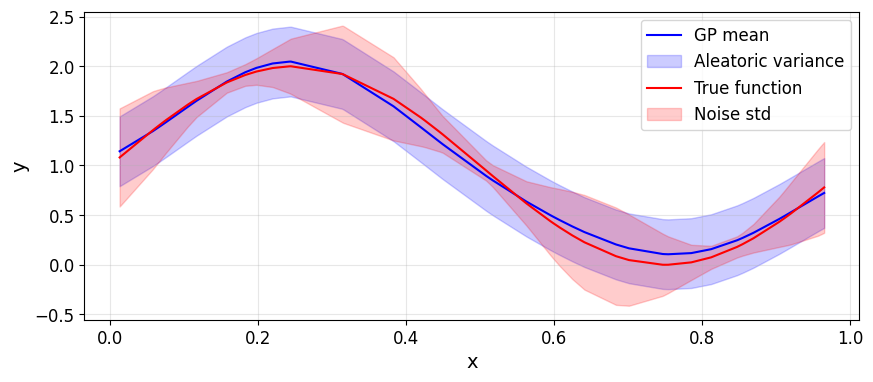

In [58]:
# make predictions
model.eval()
likelihood.eval()

test_x = torch.rand(50)
test_x = torch.sort(test_x)[0]
f_preds = model(test_x) # distribution of noiseless predictions
y_preds = likelihood(f_preds) # distribution of noisy predictions
# statistics of the distributions
f_means = f_preds.mean.detach().numpy() # GP posterior mean of the function
f_vars = f_preds.variance.detach().numpy() # GP posterior variance of the function
y_vars = y_preds.variance.detach().numpy()  # GP posterior variance + likelihood variance
aleatoric_vars = y_vars - f_vars

# compare the learnt f_means with the true function
plt.figure(figsize=(10, 4))
plt.grid(True, alpha=0.3)
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(test_x, f_means, 'b-', label='GP mean')
# fill between with y_vars standard deviation
plt.fill_between(test_x, f_means - np.sqrt(aleatoric_vars), f_means + np.sqrt(aleatoric_vars), color='b', alpha=0.2, label='Aleatoric variance')
plt.plot(test_x, f(test_x), 'r-', label='True function')
plt.fill_between(test_x, f(test_x) - np.sqrt(noise_std(test_x)**2), f(test_x) + np.sqrt(noise_std(test_x)**2), color='r', alpha=0.2, label='Noise std')
plt.legend(fontsize=12)
plt.show()

In [59]:
print(f_vars) # epistemic uncertainty

[0.01495202 0.00812603 0.00796088 0.00759753 0.00733372 0.00690182
 0.00681877 0.00646525 0.00619188 0.00603789 0.00584452 0.00567136
 0.00565505 0.00506264 0.00504836 0.00504453 0.00558059 0.00569511
 0.00606925 0.0061467  0.00708573 0.00714067 0.00717558 0.0071868
 0.00747302 0.00751318 0.00751305 0.00751102 0.0075045  0.0074817
 0.00746189 0.00752548 0.00764211 0.00822455 0.00826991 0.00834799
 0.00884817 0.00885047 0.00914173 0.00915009 0.00910124 0.00909515
 0.00896312 0.00885567 0.00899407 0.0091022  0.00921017 0.01253472
 0.01341522 0.01407904]


In [60]:
print(aleatoric_vars)

[0.12350085 0.12350086 0.12350085 0.12350086 0.12350086 0.12350086
 0.12350086 0.12350087 0.12350085 0.12350085 0.12350086 0.12350085
 0.12350085 0.12350087 0.12350085 0.12350086 0.12350087 0.12350087
 0.12350085 0.12350085 0.12350086 0.12350085 0.12350087 0.12350086
 0.12350085 0.12350087 0.12350085 0.12350085 0.12350086 0.12350086
 0.12350085 0.12350086 0.12350087 0.12350086 0.12350087 0.12350086
 0.12350086 0.12350087 0.12350085 0.12350085 0.12350086 0.12350086
 0.12350086 0.12350087 0.12350086 0.12350086 0.12350087 0.12350086
 0.12350085 0.12350086]


In [61]:
# calcualte average true noise variance
true_noise_var = noise_std(test_x)**2
true_noise_var.mean()

tensor(0.0957)

# Heteroscedastic Noise

In [62]:
# get training and test points
n = 1000
train_x = torch.linspace(0, 1, n)
train_x = torch.sort(train_x)[0]
train_y = f(train_x) + torch.randn(n) * noise_std(train_x)

In [63]:
# Define models for mean and noise variance
class MeanGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MeanGP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class NoiseGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(NoiseGP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [64]:
# Step 1: Train the mean GP model
# Initialize likelihood and model
mean_likelihood = gpytorch.likelihoods.GaussianLikelihood()
mean_model = MeanGP(train_x, train_y, mean_likelihood)

# Training mode
mean_model.train()
mean_likelihood.train()

# Use Adam optimizer
mean_optimizer = torch.optim.Adam([
    {'params': mean_model.parameters()},
], lr=0.1)

# Loss function: marginal log likelihood
mean_mll = gpytorch.mlls.ExactMarginalLogLikelihood(mean_likelihood, mean_model)

# Training iterations
training_iterations = 100
for i in range(training_iterations):
    # Zero gradients
    mean_optimizer.zero_grad()
    
    # Output from model
    output = mean_model(train_x)
    
    # Calculate loss and backpropagate
    loss = -mean_mll(output, train_y)
    loss.backward()
    mean_optimizer.step()
    
    if (i+1) % 20 == 0:
        print(f'Mean GP - Iter {i+1}/{training_iterations} - Loss: {loss.item():.3f}')

Mean GP - Iter 20/100 - Loss: 0.353
Mean GP - Iter 40/100 - Loss: 0.337
Mean GP - Iter 60/100 - Loss: 0.329
Mean GP - Iter 80/100 - Loss: 0.330
Mean GP - Iter 100/100 - Loss: 0.334


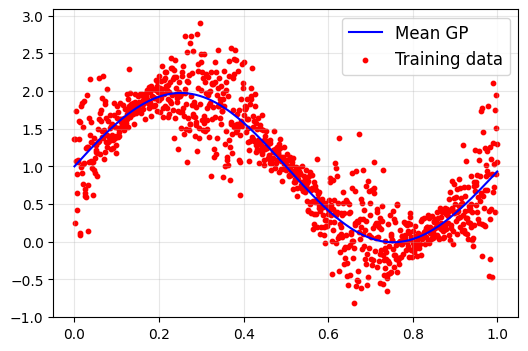

In [75]:
# Set the mean model to evaluation mode
mean_model.eval()
mean_likelihood.eval()
with torch.no_grad():
    mean_pred = mean_model(train_x).mean

plt.figure(figsize=(6, 4))
plt.grid(alpha=0.3)
plt.plot(train_x, mean_pred, 'b-', label='Mean GP')
plt.scatter(train_x, train_y, c='r', label='Training data', s=10)
plt.legend(fontsize=12)
plt.show()

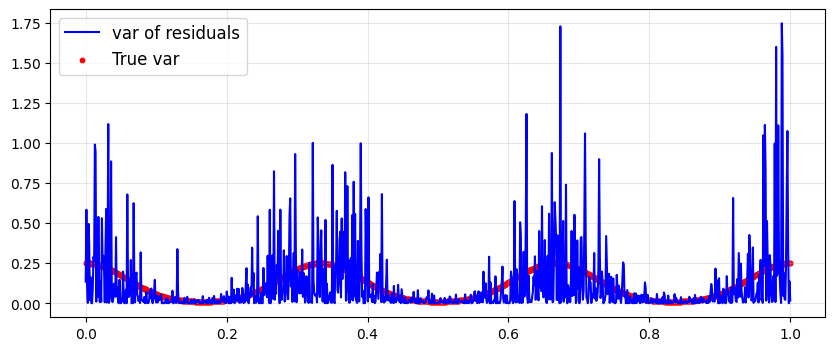

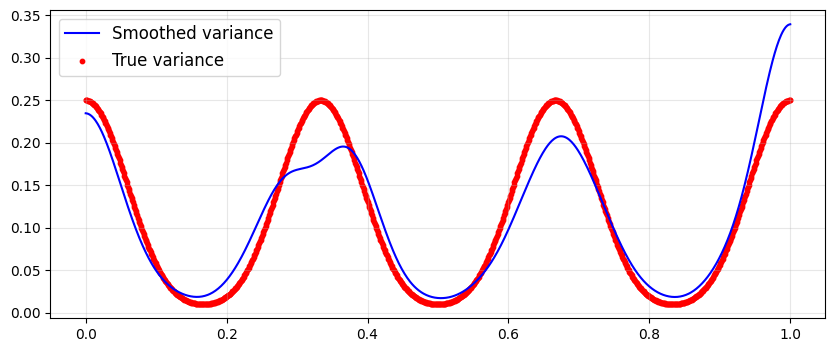

In [76]:
train_var = (train_y - mean_pred)**2
plt.figure(figsize=(10, 4))
plt.grid(alpha=0.3)
plt.plot(train_x, train_var, 'b-', label='var of residuals')
plt.scatter(train_x, noise_std(train_x)**2, c='r', label='True var', s=10)
plt.legend(fontsize=12)
plt.show()

# smooth the variance
from scipy.ndimage import gaussian_filter
train_var = gaussian_filter(train_var, sigma=30)
train_var = torch.tensor(train_var)
plt.figure(figsize=(10, 4))
plt.grid(alpha=0.3)
plt.plot(train_x, train_var, 'b-', label='Smoothed variance')
plt.scatter(train_x, noise_std(train_x)**2, c='r', label='True variance', s=10)
plt.legend(fontsize=12)

Noise GP - Iter 20/100 - Loss: -0.050
Noise GP - Iter 40/100 - Loss: -0.906
Noise GP - Iter 60/100 - Loss: -1.276
Noise GP - Iter 80/100 - Loss: -2.339
Noise GP - Iter 100/100 - Loss: -3.036


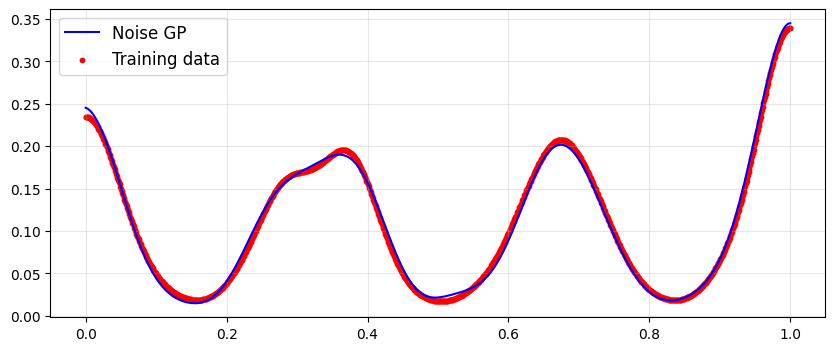

In [77]:
noise_likelihood = gpytorch.likelihoods.GaussianLikelihood()
noise_model = NoiseGP(train_x, train_var, noise_likelihood)
noise_model.train()
noise_likelihood.train()

noise_optimizer = torch.optim.Adam([
    {'params': noise_model.parameters()},
], lr=0.1)

noise_mll = gpytorch.mlls.ExactMarginalLogLikelihood(noise_likelihood, noise_model)

training_iterations = 100
for i in range(training_iterations):
    # Zero gradients
    noise_optimizer.zero_grad()

    # Output from model
    output = noise_model(train_x)
    
    # Calculate loss and backpropagate
    loss = -noise_mll(output, train_var)
    loss.backward()
    noise_optimizer.step()

    if (i+1) % 20 == 0:
        print(f'Noise GP - Iter {i+1}/{training_iterations} - Loss: {loss.item():.3f}')

noise_model.eval()
noise_likelihood.eval()

# Plot the results
plt.figure(figsize=(10, 4))
plt.grid(alpha=0.3)
plt.plot(train_x, noise_model(train_x).mean.detach().numpy(), 'b-', label='Noise GP')
plt.scatter(train_x, train_var, c='r', label='Training data', s=10)
plt.legend(fontsize=12)
plt.show()

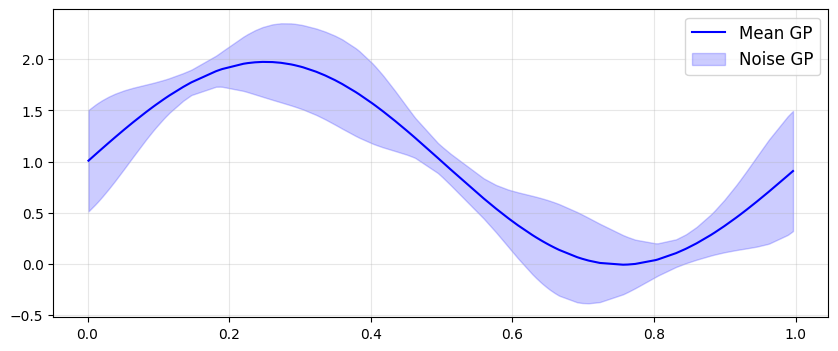

In [78]:
mean_model.eval()
mean_likelihood.eval()
noise_model.eval()
noise_likelihood.eval()

test_x = torch.rand(100)
test_x = torch.sort(test_x)[0]
# Make predictions
with torch.no_grad():
    # Mean predictions
    mean_pred = mean_model(test_x).mean
    
    # Log-variance predictions
    var_pred = noise_model(test_x).mean
    
    # Convert to variance
    std_pred = torch.sqrt(var_pred)

# Plot the results
plt.figure(figsize=(10, 4))
plt.grid(alpha=0.3)
plt.plot(test_x, mean_pred, 'b-', label='Mean GP')
# fill between with std_pred standard deviation
plt.fill_between(test_x, mean_pred - std_pred, mean_pred + std_pred, color='b', alpha=0.2, label='Noise GP')
plt.legend(fontsize=12)
plt.show()